In [ ]:
 ! pip install -q kaggle

In [ ]:
import glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
from sklearn.utils import class_weight 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sarvajith","key":"9ed3f2a8cc161358fc1fab8e8de9a7ed"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [ ]:
#Download data
! kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:45<00:00, 50.1MB/s]
100% 3.10G/3.10G [00:45<00:00, 72.5MB/s]


In [ ]:
! mkdir data
! unzip breast-histopathology-images.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: data/IDC_regular_ps50_idx5/9346/0/

In [ ]:
breast_img = glob.glob('/content/data/**/*.png', recursive = True)

In [ ]:
negative = []
positive = []

for img in tqdm(breast_img):
    if img[-5] == '0' :
        negative.append(img)
    
    elif img[-5] == '1' :
        positive.append(img)

100%|██████████| 555048/555048 [00:00<00:00, 1805472.98it/s]


In [ ]:
negative_img = []
positive_img = []

for img in tqdm(negative[:20000]):
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    n_img_size = cv2.normalize(n_img_size, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    negative_img.append([n_img_size, 0])
    
for img in tqdm(positive[:20000]):
    
    p_img = cv2.imread(img, cv2.IMREAD_COLOR)
    p_img_size = cv2.resize(p_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    p_img_size = cv2.normalize(p_img_size, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    positive_img.append([p_img_size, 1])

100%|██████████| 20000/20000 [00:05<00:00, 3934.17it/s]


In [ ]:
X = []
label = []

data = np.concatenate((negative_img, positive_img))
# random.shuffle(data)

for feature, l in tqdm(data):
    X.append(feature)
    label.append(l)
    
X = np.array(X)
label = np.array(label)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 40000/40000 [00:00<00:00, 511450.59it/s]


In [ ]:
X_train, X_predict, y_train, y_true = train_test_split(X, label, test_size = 0.2, random_state = 0)

In [ ]:
list(y_train).count(1)

16004

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))


model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))


model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 16)        18448     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 12, 12, 16)       

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
Adm = Adam(learning_rate = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = Adm, metrics = ['accuracy'])
# history = model.fit_generator(train_generator, validation_data = validation_generator, epochs = 100, callbacks=[es, mc])
history = model.fit(X_train, y_train,validation_split=0.1, epochs = 200, batch_size = 256, callbacks=[es, mc])


Epoch 1/200
113/113 [==============================] - 32s 247ms/step - loss: 0.5550 - accuracy: 0.7139 - val_loss: 0.5225 - val_accuracy: 0.7609

Epoch 00001: val_accuracy improved from -inf to 0.76094, saving model to best_model.h5
Epoch 2/200
113/113 [==============================] - 26s 231ms/step - loss: 0.4687 - accuracy: 0.7794 - val_loss: 0.4590 - val_accuracy: 0.7844

Epoch 00002: val_accuracy improved from 0.76094 to 0.78438, saving model to best_model.h5
Epoch 3/200
113/113 [==============================] - 26s 231ms/step - loss: 0.4455 - accuracy: 0.7944 - val_loss: 0.4882 - val_accuracy: 0.7613

Epoch 00003: val_accuracy did not improve from 0.78438
Epoch 4/200
113/113 [==============================] - 26s 231ms/step - loss: 0.4280 - accuracy: 0.8061 - val_loss: 0.4470 - val_accuracy: 0.7912

Epoch 00004: val_accuracy improved from 0.78438 to 0.79125, saving model to best_model.h5
Epoch 5/200
113/113 [==============================] - 26s 231ms/step - loss: 0.4168 - acc

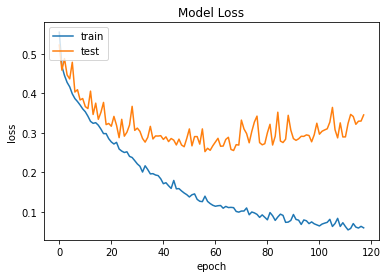

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
saved_model = load_model('best_model.h5')
y_pred = saved_model.predict(X_predict)
y_pred = [1 if x>=0.5 else 0 for x in y_pred]
confusion_matrix(y_true,y_pred)

array([[3678,  326],
       [ 275, 3721]])

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4004
           1       0.92      0.93      0.93      3996

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000

